In [4]:
#!pip install kaggle
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -o intel-image-classification.zip &> /dev/null


In [2]:
!mkdir seg_val && mv seg_test/seg_test/** seg_val/ && rm -rf seg_test**
!mkdir seg_test && mv seg_pred/seg_pred/** seg_test/ && rm -rf seg_pred**
!mv seg_train/seg_train/** seg_train/ && rm -rf seg_train/seg_train

In [3]:
import glob
import os

# fileList = glob.glob('seg_**/**/*.jpg', recursive=True)
# for file in fileList:
#     if len(os.path.basename(file)) > 6:
#         os.remove(file)

folders = ['seg_train', 'seg_val']
for folder in folders:
    for dir in os.listdir(folder):
        i = 0
        files = sorted(os.listdir(os.path.join(folder, dir)))
        for file in sorted(os.listdir(os.path.join(folder, dir))):
            if i > 10 and len(files) > 20:
                os.remove(os.path.join(os.path.join(folder, dir), file))
            i += 1

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [21]:
train_dir = './seg_train'
val_dir = './seg_val'

In [22]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 66 files belonging to 6 classes.
Using 53 files for training.
Found 66 files belonging to 6 classes.
Using 13 files for validation.


2022-04-22 11:59:21.870348: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
images = [train_ds.take(1)]
images[0]

<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [28]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [24]:
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


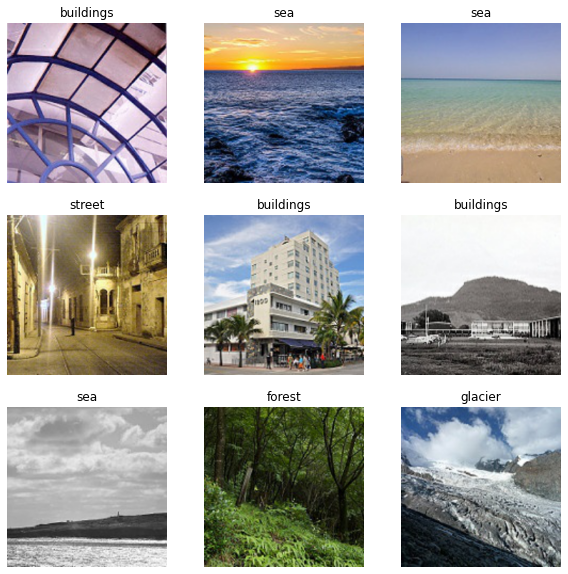

In [27]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")